## 1. Load Data

In [23]:
include("src/objects/Polypeptide.jl")

X = from_pdb("1A3N", "A")
Y = from_pdb("4ZVA", "A")
render_aligned(X, Y)

[ Info: File exists: 1A3N
[ Info: File exists: 4ZVA
[ Info: Superimposing based on a sequence alignment between 119 residues
[ Info: Superimposing based on 119 atoms
[ Info: Model 1 with 2 chains (1,2), 290 residues, 2542 atoms


HTML{String}("<script type='text/javascript'>/*! jQuery v3.3.1 | (c) JS Foundation and other contributors | jquery.org/license */\n!function(e,t){\"use strict\";\"object\"==typeof module&&\"object\"==typeof module.exports?module.exports=e.document?t(e,!0):function(e){if(!e.document)throw new Error(\"jQuery requires a window with a document\");return t(e)}:t(e)}(\"undefined\"!=typeof window?window:this,function(e,t){\"use strict\";var n=[],r=e.document,i=Object.getPrototypeOf,o=n.slice,a=n.concat,s=n.push,u=n.indexOf,l={},c=l.toString,f=l.hasOwnProperty,p=f.toString,d=p.call(Object),h={},g=function e(t){return\"function\"==typeof t&&\"number\"!=typeof t.nodeType},y=function e(t){return null!=t&&t===t.window},v={type:!0,src:!0,noModule:!0};function m(e,t,n){var i,o=(t=t||r).createElement(\"script\");if(o.text=e,n)for(i in v)n[i]&&(o[i]=n[i]);t.head.appendChild(o).parentNode.removeChild(o)}function x(e){return null==e?e+\"\":\"object\"==typeof e||\"function\"==typeof e?l[c.call(e)]||\"object\":typeof e}var b=\"3.3.1\",w=function(e,t){return new w.fn.init(e,t)},T=/^[\\s\\uFEFF\\xA0]+|[\\s\\uFEFF\\xA0]+\$/g;w.fn=w.prototype={jquery:\"3.3.1\",constructor:w,length:0,toArray:function(){return o.call(this)},get:function(e){return null==e?o.call(this):e<0?this[e+this.length]:this[e]},pushStack:function(e){var t=w.merge(this.constructor(),e);return t.prevObject=this,t},each:function(e){return w.each(this,e)},map:function(e){return this.pushStack(w.map(this,function(t,n){return e.call(t,n,t)}))},slice:function(){return this.pushStack(o.apply(this,arguments))},first:function(){return this.eq(0)},last:function(){return this.eq(-1)},eq:function(e){var t=this.length,n=+e+(e<0?t:0);return this.pushStack(n>=0&&n<t?[this[n]]:[])},end:function(){return this.prevObject||this.constructor()},push:s,sort:n.sort,splice:n.splice},w.extend=w.fn.extend=function(){var e,t,n,r,i,o,a=arguments[0]||{},s=1,u=arguments.length,l=!1;for(\"boolean\"==typeof a&&(l=a,a=arguments[s]||{},s++),\"object\"==typeof a||g(a)||(a={}),s===u&&(a=this,s--);s<u;s++)if(null!=(e=arguments[s]))for(t in e)n=a[t],a!==(r=e[t])&&(l&&r&&(w.isPlainObject(r)||(i=Array.isArray(r)))?(i?(i=!1,o=n&&Array.isArray(n)?n:[]):o=n&&w.isPlainObject(n)?n:{},a[t]=w.extend(l,o,r)):void 0!==r&&(a[t]=r));return a},w.extend({expando:\"jQuery\"+(\"3.3.1\"+Math.random()).replace(/\\D/g,\"\"),isReady:!0,error:function(e){throw new Error(e)},noop:function(){},isPlainObject:function(e){var t,n;return!(!e||\"[object Object]\"!==c.call(e))&&(!(t=i(e))||\"function\"==typeof(n=f.call(t,\"constructor\")&&t.constructor)&&p.call(n)===d)},isEmptyObject:function(e){var t;for(t in e)return!1;return!0},globalEval:function(e){m(e)},each:function(e,t){var n,r=0;if(C(e)){for(n=e.length;r<n;r++)if(!1===t.call(e[r],r,e[r]))break}else for(r in e)if(!1===t.call(e[r],r,e[r]))break;return e},trim:function(e){return null==e?\"\":(e+\"\").replace(T,\"\")},makeArray:function(e,t){var n=t||[];return null!=e&&(C(Object(e))?w.merge(n,\"string\"==typeof e?[e]:e):s.call(n,e)),n},inArray:function(e,t,n){return null==t?-1:u.call(t,e,n)},merge:function(e,t){for(var n=+t.length,r=0,i=e.length;r<n;r++)e[i++]=t[r];return e.length=i,e},grep:function(e,t,n){for(var r,i=[],o=0,a=e.length,s=!n;o<a;o++)(r=!t(e[o],o))!==s&&i.push(e[o]);return i},map:function(e,t,n){var r,i,o=0,s=[];if(C(e))for(r=e.length;o<r;o++)null!=(i=t(e[o],o,n))&&s.push(i);else for(o in e)null!=(i=t(e[o],o,n))&&s.push(i);return a.apply([],s)},guid:1,support:h}),\"function\"==typeof Symbol&&(w.fn[Symbol.iterator]=n[Symbol.iterator]),w.each(\"Boolean Number String Function Array Date RegExp Object Error Symbol\".split(\" \"),function(e,t){l[\"[object \"+t+\"]\"]=t.toLowerCase()});function C(e){var t=!!e&&\"length\"in e&&e.length,n=x(e);return!g(e)&&!y(e)&&(\"array\"===n||0===t||\"number\"==typeof t&&t>0&&t-1 in e)}var E=function(e){var t,n,r,i,o,a,s,u,l,c,f,p,d,h,g,y,v,m,x,b=\"sizzle\"+1*new Date,w=e.document,T=0,C=0,E=ae(),k=ae(),S=ae(),D=function(e,t){return e===t&&(f=!0),0},N

In [22]:
Y = from_pdb("1MBN", "A")
render(Y)

[ Info: File exists: 1MBN


HTML{String}("<script type='text/javascript'>/*! jQuery v3.3.1 | (c) JS Foundation and other contributors | jquery.org/license */\n!function(e,t){\"use strict\";\"object\"==typeof module&&\"object\"==typeof module.exports?module.exports=e.document?t(e,!0):function(e){if(!e.document)throw new Error(\"jQuery requires a window with a document\");return t(e)}:t(e)}(\"undefined\"!=typeof window?window:this,function(e,t){\"use strict\";var n=[],r=e.document,i=Object.getPrototypeOf,o=n.slice,a=n.concat,s=n.push,u=n.indexOf,l={},c=l.toString,f=l.hasOwnProperty,p=f.toString,d=p.call(Object),h={},g=function e(t){return\"function\"==typeof t&&\"number\"!=typeof t.nodeType},y=function e(t){return null!=t&&t===t.window},v={type:!0,src:!0,noModule:!0};function m(e,t,n){var i,o=(t=t||r).createElement(\"script\");if(o.text=e,n)for(i in v)n[i]&&(o[i]=n[i]);t.head.appendChild(o).parentNode.removeChild(o)}function x(e){return null==e?e+\"\":\"object\"==typeof e||\"function\"==typeof e?l[c.call(e)]||\"object\":typeof e}var b=\"3.3.1\",w=function(e,t){return new w.fn.init(e,t)},T=/^[\\s\\uFEFF\\xA0]+|[\\s\\uFEFF\\xA0]+\$/g;w.fn=w.prototype={jquery:\"3.3.1\",constructor:w,length:0,toArray:function(){return o.call(this)},get:function(e){return null==e?o.call(this):e<0?this[e+this.length]:this[e]},pushStack:function(e){var t=w.merge(this.constructor(),e);return t.prevObject=this,t},each:function(e){return w.each(this,e)},map:function(e){return this.pushStack(w.map(this,function(t,n){return e.call(t,n,t)}))},slice:function(){return this.pushStack(o.apply(this,arguments))},first:function(){return this.eq(0)},last:function(){return this.eq(-1)},eq:function(e){var t=this.length,n=+e+(e<0?t:0);return this.pushStack(n>=0&&n<t?[this[n]]:[])},end:function(){return this.prevObject||this.constructor()},push:s,sort:n.sort,splice:n.splice},w.extend=w.fn.extend=function(){var e,t,n,r,i,o,a=arguments[0]||{},s=1,u=arguments.length,l=!1;for(\"boolean\"==typeof a&&(l=a,a=arguments[s]||{},s++),\"object\"==typeof a||g(a)||(a={}),s===u&&(a=this,s--);s<u;s++)if(null!=(e=arguments[s]))for(t in e)n=a[t],a!==(r=e[t])&&(l&&r&&(w.isPlainObject(r)||(i=Array.isArray(r)))?(i?(i=!1,o=n&&Array.isArray(n)?n:[]):o=n&&w.isPlainObject(n)?n:{},a[t]=w.extend(l,o,r)):void 0!==r&&(a[t]=r));return a},w.extend({expando:\"jQuery\"+(\"3.3.1\"+Math.random()).replace(/\\D/g,\"\"),isReady:!0,error:function(e){throw new Error(e)},noop:function(){},isPlainObject:function(e){var t,n;return!(!e||\"[object Object]\"!==c.call(e))&&(!(t=i(e))||\"function\"==typeof(n=f.call(t,\"constructor\")&&t.constructor)&&p.call(n)===d)},isEmptyObject:function(e){var t;for(t in e)return!1;return!0},globalEval:function(e){m(e)},each:function(e,t){var n,r=0;if(C(e)){for(n=e.length;r<n;r++)if(!1===t.call(e[r],r,e[r]))break}else for(r in e)if(!1===t.call(e[r],r,e[r]))break;return e},trim:function(e){return null==e?\"\":(e+\"\").replace(T,\"\")},makeArray:function(e,t){var n=t||[];return null!=e&&(C(Object(e))?w.merge(n,\"string\"==typeof e?[e]:e):s.call(n,e)),n},inArray:function(e,t,n){return null==t?-1:u.call(t,e,n)},merge:function(e,t){for(var n=+t.length,r=0,i=e.length;r<n;r++)e[i++]=t[r];return e.length=i,e},grep:function(e,t,n){for(var r,i=[],o=0,a=e.length,s=!n;o<a;o++)(r=!t(e[o],o))!==s&&i.push(e[o]);return i},map:function(e,t,n){var r,i,o=0,s=[];if(C(e))for(r=e.length;o<r;o++)null!=(i=t(e[o],o,n))&&s.push(i);else for(o in e)null!=(i=t(e[o],o,n))&&s.push(i);return a.apply([],s)},guid:1,support:h}),\"function\"==typeof Symbol&&(w.fn[Symbol.iterator]=n[Symbol.iterator]),w.each(\"Boolean Number String Function Array Date RegExp Object Error Symbol\".split(\" \"),function(e,t){l[\"[object \"+t+\"]\"]=t.toLowerCase()});function C(e){var t=!!e&&\"length\"in e&&e.length,n=x(e);return!g(e)&&!y(e)&&(\"array\"===n||0===t||\"number\"==typeof t&&t>0&&t-1 in e)}var E=function(e){var t,n,r,i,o,a,s,u,l,c,f,p,d,h,g,y,v,m,x,b=\"sizzle\"+1*new Date,w=e.document,T=0,C=0,E=ae(),k=ae(),S=ae(),D=function(e,t){return e===t&&(f=!0),0},N

## 2. Prepare Evolutionary Regimes

In [1]:
include("src/distributions/WrappedNormal.jl")
include("src/distributions/Processes.jl")
include("src/distributions/WrappedDiffusion.jl")
include("src/distributions/Common.jl")
include("src/distributions/JumpingProcess.jl")
using Base.Threads


nthreads()

10

In [2]:
using Turing
using StatsPlots
using DistributionsAD
using ReverseDiff
Turing.setadbackend(:reversediff)
Turing.setrdcache(true)

@model function wntest(x)
    #μ ~ WrappedNormal([0.0, 0.0], [3.0 0.0; 0.0 3.0])
    #μ ~ filldist(Uniform(-π, π), 2)
    μ = [-1.0, 1.0]
    t = 0.01
    γ ~ Exponential(0.01)
    Σ = [1.0 0.0; 0.0 1.0]
    origin = [-2.0, -3.0]
    diff = jumping(WrappedDiffusion(μ, 1.0, 1.0, 1.0, 1.0, 0.1), γ)
    dist = transdist(diff, t, origin)
    x ~ dist
end

wntest (generic function with 2 methods)

In [13]:
function fun()
    μ = [-1.0, 1.0]
    Σ = [1.0 0.0; 0.0 1.0]
    t = 0.01
    γ = 360.0
    
    diff = jumping(WrappedDiffusion(μ, 1.0, 1.0, 1.0, 1.0, 0.1), γ)
    origin = [-2.0, -3.0]
    
    dist = transdist(diff, t, origin)
    
    x = rand(dist, 100)
    numsamples = 1000
    model = wntest(x)
    #alg1 = Gibbs(MH(:μ), HMC(0.2, 100, :γ))
    alg1 = HMC(0.5, 100, :γ)
    chains = sample(model, alg1, numsamples)
    plot(chains[["γ"]]; colordim=:parameter, legend=true)
end



fun (generic function with 1 method)

  0.089292 seconds (190.58 k allocations: 12.646 MiB)


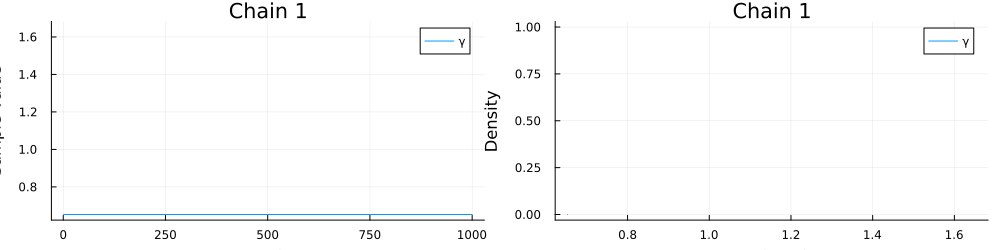

In [14]:
@time fun()

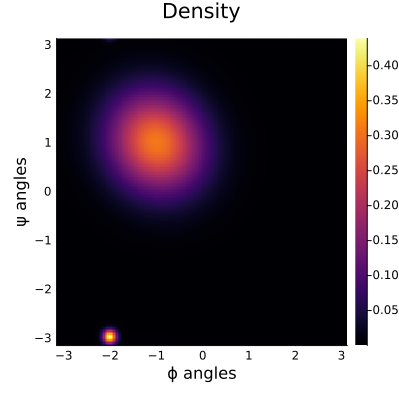

In [65]:
μ = [-1.0, 1.0]
Σ = [1.0 0.0; 0.0 1.0]
t = 0.01
γ = 360.0
    
diff = jumping(WrappedDiffusion(μ, 1.0, 1.0, 1.0, 1.0, 0.1), γ)
origin = [-2.0, -3.0]
    
dist = transdist(diff, t, origin)
plotpdf(dist)